# DME project - Classification models
This notebook contains the classification models done for predicting the cuisines recipes using the `recipes.csv` data file from Bellosi (2011)

In [ ]:
# Install required packages
!pip install -q -r requirements.txt

In [2]:
# Data libraries
import numpy as np
import pandas as pd

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras import layers

# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# misc libraries
import time
import random

In [3]:
# umap
!pip install umap-learn

     |████████████████████████████████| 81kB 6.6MB/s 
     |████████████████████████████████| 1.2MB 21.9MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=36d8bf0ae72587c120ef9f85f4f869b3a389dac49897d6c4ad66dcd666d412c0
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=e33be43aae60e28d7707d868d527a9fc04dff12632bedb4abc7725f641c33da8
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [4]:
import umap.umap_ as umap

---
# Data import and preparation

In [5]:
recipes_df = pd.read_csv('recipes.csv')
recipes_df.head()

,'acorn squash',adobo,'african birdseye chile pepper',ale,'aleppo pepper','alfalfa sprouts','alfredo sauce',allspice,almond,'almond butter',amaretti,'amchoor powder','ancho chile pepper',anchovy,'anchovy paste','andouille sausage',anise,apple,'apple butter','apple juice',applesauce,apricot,'arborio rice','argan oil',arrowroot,artichoke,'artificial sweetener',arugula,asadero,asafetida,'asiago cheese',asparagus,'assorted vegetables',avocado,'azuki bean','baby carrot','baby corn','baby onions','baby spinach',bacon,...,vermouth,'Vidalia onion',vinegar,'vital wheat gluten',vodka,walnut,wasabi,'washed rind cheese',water,'water chestnut',watercress,watermelon,'wheat bread','whipping cream','white bean','white bread','white cheese','white fish','white onion','white peppercorns','white sesame seeds','whole grain mustard','whole milk','wild rice',wine,'wine vinegar','winter squash','worcestershire sauce','xanthan gum',yams,yeast,'yellow curry paste','yellow food coloring','yellow split pea','yellow squash',yogurt,zaatar,zest,zucchini,cuisine
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
recipes_df.cuisine.value_counts()

11    353
7     353
3     353
10    353
6     353
2     353
9     353
5     353
1     353
8     353
4     353
0     353
Name: cuisine, dtype: int64

In [7]:
recipes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4236 entries, 0 to 4235
Columns: 710 entries, 'acorn squash' to cuisine
dtypes: int64(710)
memory usage: 22.9 MB


### Clean column names

In [8]:
for column in recipes_df.columns:
  recipes_df.rename(columns={column:column.replace(' ', '_').replace("'", "")}, inplace=True)
  recipes_df.rename(columns={column:column.lower()}, inplace=True)

recipes_df.head()

,acorn_squash,adobo,african_birdseye_chile_pepper,ale,aleppo_pepper,alfalfa_sprouts,alfredo_sauce,allspice,almond,almond_butter,amaretti,amchoor_powder,ancho_chile_pepper,anchovy,anchovy_paste,andouille_sausage,anise,apple,apple_butter,apple_juice,applesauce,apricot,arborio_rice,argan_oil,arrowroot,artichoke,artificial_sweetener,arugula,asadero,asafetida,asiago_cheese,asparagus,assorted_vegetables,avocado,azuki_bean,baby_carrot,baby_corn,baby_onions,baby_spinach,bacon,...,vermouth,Vidalia_onion,vinegar,vital_wheat_gluten,vodka,walnut,wasabi,washed_rind_cheese,water,water_chestnut,watercress,watermelon,wheat_bread,whipping_cream,white_bean,white_bread,white_cheese,white_fish,white_onion,white_peppercorns,white_sesame_seeds,whole_grain_mustard,whole_milk,wild_rice,wine,wine_vinegar,winter_squash,worcestershire_sauce,xanthan_gum,yams,yeast,yellow_curry_paste,yellow_food_coloring,yellow_split_pea,yellow_squash,yogurt,zaatar,zest,zucchini,cuisine
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Create train, validation and test split

In [24]:
train, val = train_test_split(recipes_df, test_size=0.3, random_state=42, stratify=recipes_df['cuisine'])
val, test = train_test_split(val, test_size=(1/3), random_state=42, stratify=val['cuisine'])
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')
print(f'Percentage of train examples: {round(len(train) / len(recipes_df)*100)}%')
print(f'Percentage of validation examples: {round(len(val) / len(recipes_df)*100)}%')
print(f'Percentage of test examples: {round(len(test) / len(recipes_df)*100)}%')

2965 train examples
847 validation examples
424 test examples
Percentage of train examples: 70%
Percentage of validation examples: 20%
Percentage of test examples: 10%


## Dimensionally reduced versions of dataset

In [17]:
y_train = train.pop('cuisine')
X_train = train
y_val = val.pop('cuisine')
X_val = val
y_test = test.pop('cuisine')
X_test = test

### PCA

In [18]:
# PCA reduced version of train, valid and test data
pca = PCA(n_components=71)
pca.fit(X_train)
X_train_PCA = pca.transform(X_train)
X_val_PCA = pca.transform(X_val)
X_test_PCA = pca.transform(X_test)

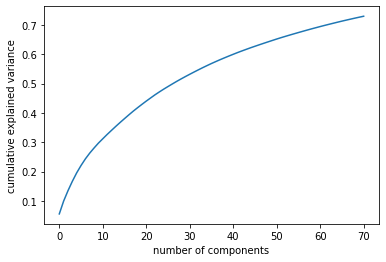

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### UMAP

In [ ]:
reducer = umap.UMAP(metric="braycurtis", n_neighbors=20, random_state=26, n_components=2) # roughly 1% of the number of original features
reducer.fit(X_train)

UMAP(a=None, angular_rp_forest=False, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='braycurtis',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None, n_jobs=-1,
     n_neighbors=20, negative_sample_rate=5, output_dens=False,
     output_metric='euclidean', output_metric_kwds=None, random_state=26,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None, ...)

In [ ]:
X_train_umap = reducer.transform(X_train)
X_val_umap = reducer.transform(X_val)
X_test_umap = reducer.transform(X_test)

---
# Model training

## Model 1 - simple neural network

### Create TensorFlow dataset

#### Dataset with original feature representation data

In [30]:
# TensorFlow dataset from CSV
def df_to_dataset(dataframe, shuffle=True, batch_size=64):
  dataframe = dataframe.copy()
  labels = dataframe.pop('cuisine')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe), reshuffle_each_iteration=True)
  ds = ds.batch(batch_size)
  return ds

In [31]:
feature_columns = []

for header in recipes_df.iloc[:,:-1].columns:
  feature_columns.append(tf.feature_column.numeric_column(header, 1))

In [32]:
# Creating batches of data for mini-batch stochastic gradient descent
batch_size = 64
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# train_ds = train_ds.shuffle(296, reshuffle_each_iteration=True)

#### Dataset with PCA/UMAP data

In [ ]:
SHUFFLE_BUFFER_SIZE = len(train)
train_ds = tf.data.Dataset.from_tensor_slices((X_train_umap, tf.one_hot(y_train, 12)))
val_ds = tf.data.Dataset.from_tensor_slices((X_val_umap, tf.one_hot(y_val, 12)))
test_ds = tf.data.Dataset.from_tensor_slices((X_test_umap, tf.one_hot(y_test, 12)))

train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True).batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

### Training model on original feature representation data 

In [28]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
            patience=10,
            monitor='val_loss',
            verbose=1,
            mode='min',
            restore_best_weights=True)

In [44]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=1e-4)),
  layers.Dropout(0.5),
  layers.Dense(12, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-4))
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.metrics.SparseCategoricalAccuracy())

# model.summary()

model.fit(train_ds,
          validation_data=val_ds,
          callbacks=[early_stop_callback],
          epochs=1000)

Epoch 1/1000
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
47/47 [==============================] - ETA: 0s - loss: 2.4205 - sparse_categorical_accuracy: 0.1869WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'acorn_squash': <tf.Tensor 'ExpandDims_20:0' shape=(None, 1) dtype=int64>, 'adobo': <tf.Tensor 'ExpandDims_21:0' shape=(None, 1) dtype=int64>, 'african_birdseye_chile_pepper': <tf.Tensor 'ExpandDims_22:0' shape=(None, 1) dtype=int64>, 'ale': <tf.Tensor 'ExpandDims_23:0' shape=(None, 1) dtype=int64>, 'aleppo_pepper': <tf.Tensor 'ExpandDims_24:0' shape=(None, 1) dtype=int64>, 'alfalfa_sprouts': <tf.Tensor 'ExpandDims_25:0' shape=(None, 1) dtype=int64>, 'alfredo_sauce': <tf.Tensor 'ExpandDims_26:0' shape=(None, 1) dtype=int64>, 'allspice': <tf.Tensor 'ExpandDims_27:0' shape=(None, 1) dtype=int64>, 'almond': <tf.Tensor 'ExpandDims_28:0' shape=(

In [ ]:
test_losss, test_accuracy = model.evaluate(test_ds)
print(test_accuracy)

7/7 [==============================] - 1s 45ms/step - loss: 0.7165 - sparse_categorical_accuracy: 0.7925
0.7924528121948242


#### Confusion matrix for original feature representation data

In [42]:
test_results = model.predict(test_ds)
test_results = [np.argmax(x) for x in test_results]

In [37]:
# Import cuisine labels
cuisines_df = pd.read_csv('Cuisines.csv', header=None)
cuisine_labels = cuisines_df[1].values
print(cuisine_labels)
cuisines_df.head()

['Chinese' 'English' 'French' 'German' 'Greek' 'Indian' 'Italian'
 'Japanese' 'Mexican' 'Moroccan' 'Spanish' 'Thai']


,0,1
0,1,Chinese
1,2,English
2,3,French
3,4,German
4,5,Greek


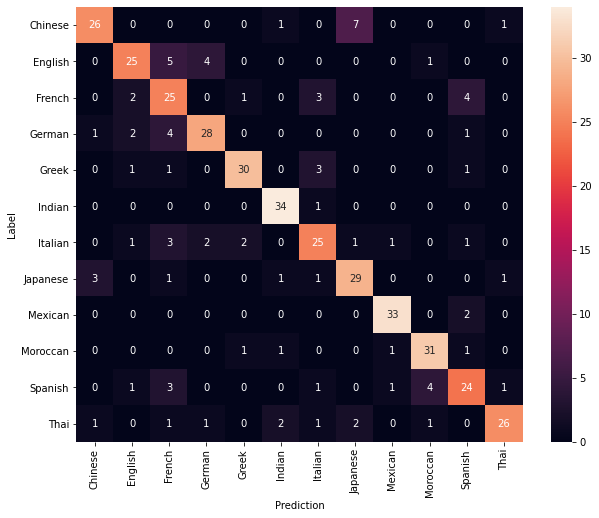

In [ ]:
# Plot confusion matrix
confusion_mtx = tf.math.confusion_matrix(test.cuisine.values, test_results) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=cuisine_labels, yticklabels=cuisine_labels, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('confusion_matrix.pdf', pad_inches=0)
plt.show()

### Training model on PCA/UMAP data

In [ ]:
model = tf.keras.Sequential([
  layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=1e-4)),
  layers.Dropout(0.5),
  layers.Dense(12, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-4))
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=tf.metrics.CategoricalAccuracy())

model.fit(train_ds,
          validation_data=val_ds,
          callbacks=[early_stop_callback],
          batch_size=64,
          epochs=1000)

Epoch 1/1000
47/47 [==============================] - 1s 5ms/step - loss: 3.0407 - categorical_accuracy: 0.1048 - val_loss: 2.1540 - val_categorical_accuracy: 0.2078
Epoch 2/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.3806 - categorical_accuracy: 0.1647 - val_loss: 1.9962 - val_categorical_accuracy: 0.2361
Epoch 3/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.1653 - categorical_accuracy: 0.2147 - val_loss: 1.9272 - val_categorical_accuracy: 0.2538
Epoch 4/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.0432 - categorical_accuracy: 0.2298 - val_loss: 1.8831 - val_categorical_accuracy: 0.2810
Epoch 5/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.9488 - categorical_accuracy: 0.2729 - val_loss: 1.8536 - val_categorical_accuracy: 0.2940
Epoch 6/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.9101 - categorical_accuracy: 0.2718 - val_loss: 1.8309 - val_categorical_accuracy: 0.3058
Epoc

In [ ]:
# PCA
test_losss, test_accuracy = model.evaluate(test_ds)
print(test_accuracy)

7/7 [==============================] - 0s 2ms/step - loss: 0.8669 - categorical_accuracy: 0.7146
0.7146226167678833


In [ ]:
# UMAP
test_losss, test_accuracy = model.evaluate(test_ds)
print(test_accuracy)

7/7 [==============================] - 0s 1ms/step - loss: 1.5682 - categorical_accuracy: 0.5896
0.5896226167678833


## Model 2 - Logistic Regression

In [ ]:
clf = LogisticRegression(random_state=0, max_iter=300, C=0.8).fit(X_train, y_train)
clf.predict(X_val)
clf.score(X_val, y_val)

0.7756788665879575

In [ ]:
clf.score(X_test, y_test)

0.7665094339622641

In [ ]:
# With dimensionally reduced data
clf = LogisticRegression(random_state=0, max_iter=300, C=0.4).fit(X_train_PCA, y_train)
clf.predict(X_val_PCA)
clf.score(X_val_PCA, y_val)

0.7367178276269185

In [ ]:
clf.score(X_test_PCA, y_test)

0.7169811320754716

In [ ]:
# with UMAP data
clf = LogisticRegression(random_state=0, max_iter=500, C=0.5)
clf.fit(X_train_umap, y_train)
clf.score(X_val_umap, y_val)

0.5501770956316411

In [ ]:
clf.score(X_test_umap, y_test)

0.5754716981132075

## Model 3 - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, max_depth=50, random_state=0, min_samples_split=3)
clf.fit(X_train, y_train)
clf.predict(X_val)
clf.score(X_val, y_val)

0.781582054309327

In [ ]:
clf.score(X_test, y_test)

0.7311320754716981

In [ ]:
# With dimensionally reduced data
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0, min_samples_split=5)
clf.fit(X_train_PCA, y_train)
clf.score(X_val_PCA, y_val)

0.7284533648170012

In [ ]:
clf.score(X_test_PCA, y_test)

0.6698113207547169

In [ ]:
# with UMAP data
clf = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=0, min_samples_split=10)
clf.fit(X_train_umap, y_train)
clf.score(X_val_umap, y_val)

0.6210153482880756

In [ ]:
clf.score(X_test_umap, y_test)

0.5966981132075472

## Model 4 - K Nearest Neighbors

In [ ]:

neigh = KNeighborsClassifier(n_neighbors=12, n_jobs=-1, algorithm='ball_tree', leaf_size=30)
neigh.fit(X_train, y_train)
neigh.score(X_val, y_val)

0.667060212514758

In [ ]:
neigh.score(X_test, y_test)

0.6155660377358491

In [ ]:
# With dimensionally reduced data
neigh = KNeighborsClassifier(n_neighbors=15, n_jobs=-1, algorithm='ball_tree', leaf_size=30)
neigh.fit(X_train_PCA, y_train)
neigh.score(X_val_PCA, y_val)

0.6611570247933884

In [ ]:
neigh.score(X_test_PCA, y_test)

0.6132075471698113

In [ ]:
# with UMAP data
neigh = KNeighborsClassifier(n_neighbors=20, n_jobs=-1, algorithm='ball_tree', leaf_size=30)
neigh.fit(X_train_umap, y_train)
neigh.score(X_val_umap, y_val)

0.6245572609208973

In [ ]:
neigh.score(X_test_umap, y_test)

0.6037735849056604

## Model 5 - Support Vector Machine

In [ ]:
svc_clf = SVC() #C=1, degree=5 same as default
svc_clf.fit(X_train, y_train)
svc_clf.score(X_val, y_val)

0.7768595041322314

In [ ]:
svc_clf.score(X_test, y_test)

0.7452830188679245

In [ ]:
svc_clf = SVC() #C=1, degree=5 same as default
svc_clf.fit(X_train_PCA, y_train)
svc_clf.score(X_val_PCA, y_val)

0.7485242030696576

In [ ]:
svc_clf.score(X_test_PCA, y_test)

0.7099056603773585

In [ ]:
svc_clf.fit(X_train_umap, y_train)
svc_clf.score(X_val_umap, y_val)

0.6174734356552538

In [ ]:
svc_clf.score(X_test_umap, y_test)

0.5990566037735849